## CV04 - 이미지 어디까지 우려먹을까?

텐서플로우의 랜덤 augmentation API을 사용하여 훈련 데이터셋에 적용 여부에 따라   
모델의 성능이 달라지는지 확인해보자.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 적용할 데이터 불러오기

In [3]:
# 데이터 불러오기
# stanford_dogs 데이터셋 이용
# 120개의 견종, 훈련셋: 12000장, 평가셋: 8580장

import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

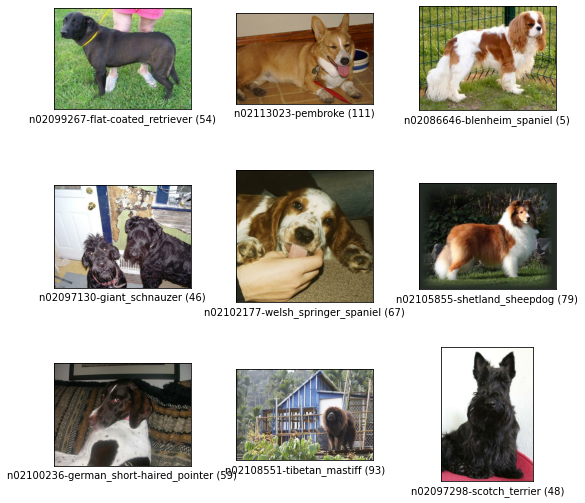

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

#### Tensorflow Random Augmentation API 사용하기

사용할 수 있는 랜덤 함수는 아래와 같다.

random_brightness()   
random_contrast()   
random_crop()   
random_flip_left_right()   
random_flip_up_down()   
random_hue()   
rnadom_jpeg_quality()   
random_saturation()   

In [9]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# 테스트셋과 훈련셋 모두 적용

In [10]:
# random_flip_left_right(), random_brightness() 적용

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [11]:
# apply_normalize_on_dataset() :원본 데이터셋에 augmentation을 적용한 가공 데이터셋을 만드는 과정을 구현하는 함수
# normalize, resize, augmentation, shuffle을 적용, 테스트셋에는 shuffle과 augmentation은 적용하지 않음
# 앙상블 방법 중에 테스트셋에 augmentation을 적용하는 test-time augmentation이라는 방법이 있다.
# https://hwiyong.tistory.com/215
# with_aug 변수: augmentation 적용여부 결정

# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [12]:
# make random augment function

def augment2(image,label):
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    return image, label

#### 비교실험 하기

In [13]:
# imagenet에 훈련된 ResNet50모델 불러오기
# include_top 변수는 마지막 fully connected layer를 포함할지 여부 결정
# 이 레이어를 포함하지 않고 생성하면 특정 추출기만 불러오고 레이어는 직접 개발 가능
# 보통 이미지넷과 우리의 테스트셋의 클래스가 다르기 때문에

num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

94773248/94765736 [==============================] - 8s 0us/step


In [14]:
# augmentation을 적용한 데이터셋을 학습시킬 ResNet

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [15]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

# augmentation을 적용한 테스트셋과 그냥 테스트셋을 따로 만든다.
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [16]:
tf.random.set_seed(2020)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 112s 150ms/step - loss: 2.1885 - accuracy: 0.4512 - val_loss: 3.6488 - val_accuracy: 0.1426
Epoch 2/20
750/750 [==============================] - 114s 152ms/step - loss: 0.7996 - accuracy: 0.7730 - val_loss: 1.0443 - val_accuracy: 0.6955
Epoch 3/20
750/750 [==============================] - 124s 165ms/step - loss: 0.2725 - accuracy: 0.9378 - val_loss: 0.9575 - val_accuracy: 0.7281
Epoch 4/20
750/750 [==============================] - 125s 166ms/step - loss: 0.0808 - accuracy: 0.9903 - val_loss: 0.9008 - val_accuracy: 0.7406
Epoch 5/20
750/750 [==============================] - 113s 151ms/step - loss: 0.0283 - accuracy: 0.9987 - val_loss: 0.9029 - val_accuracy: 0.7428
Epoch 6/20
750/750 [==============================] - 112s 150ms/step - loss: 0.0279 - accuracy: 0.9990 - val_loss: 0.9762 - val_accuracy: 0.7290
Epoch 7/20
750/750 [==============================] - 112s 149ms/step - loss: 0.0341 - accuracy: 0.9968 - val_loss: 0.9819 -

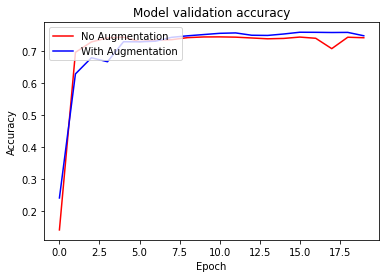

In [17]:
# 훈련 과정 시각화 해보기

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

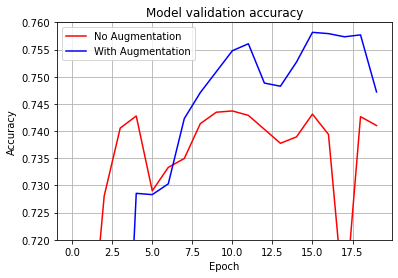

In [18]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

#### 심화 기법, Cutmix Augmentation

CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features   
https://arxiv.org/pdf/1905.04899.pdf   
CutMix: 네이버 클로바에서 제안한 방법, 이미지를 자르고 그 자리에 다른 이미지를 넣는다(Mix).   
Mixup: 특정 비율로 픽셀별 값을 섞는 방식, 50이면 개와 고양이의 이미지가 겹친다.   
Cutout: 이미지를 잘라낸다.   
Mix할 경우 라벨도 Mix, dog 0.6 cat 0.4   

Chris Deotte's CutMix and MixUp on GPU/TPU   
https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu

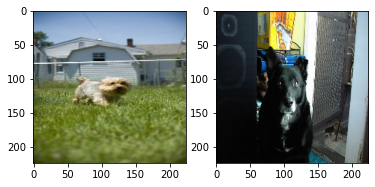

In [19]:
# 이미지 섞기
# 이미지 잘라내면 그 영역을 바운딩 박스라 한다.

import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [20]:
# 바탕이 될 이미지:A 와 삽입할 이미지:B
# A에서 바운딩 박스의 위치를 결정하는 함수 구현하기

def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(65, shape=(), dtype=int32) tf.Tensor(61, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


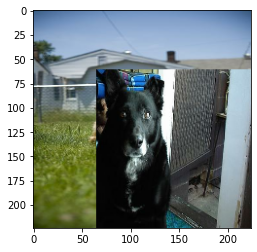

In [21]:
# A의 바운딩 박스 밖의 영역, B의 바운딩 박스 안의 영역을 각 가져와서 합치는 함수

# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [22]:
# 라벨 섞기
# 적절한 비율로 라벨을 합쳦는 함수 구현하기

# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.48347813, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [23]:
# 배치단위

def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_label


#### 심화 기법, Mixup Augmentation

mixup: Beyond Empirical Risk Minimization   
https://arxiv.org/abs/1710.09412   
두 개의 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식 

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.48347813 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.5165219  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

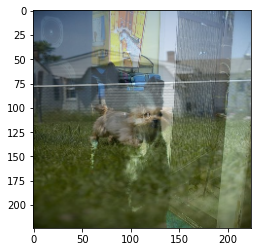

In [24]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [29]:
# 배치단위

def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels